# Predicting Wildfire Extent

## Objective
The goal of this project is to predict the final size of a wildfire using only the information that will be available when the fire is first discovered.

## Visualization 1: Heatmap With Time

We decided to make a heatmap with time in order visualize the change in density of wildfires in location across the United States over a course of 24 years. This visiualization provides an overview of the dataset as a whole. For such a large dataset (1.88 million wildfires), it is important to find an easy-to-grasp general representation of the data. This allows for an easy-to-comprehend visualization of the relationship between wildfire location, time of the year, and density of wildfires. Seasonal trends are extremely apparent as the animation cycles through each year. Notably, wildfires on the West Coast do not occur until about May to June and only last until about November. There is also a very large amount of significant wildfires in the southeast United States through a large portion of the year, especially beginning in February. All wildfires of size less than ten acres were removed from the dataset prior to generating the heatmap as they caused considerable noise and are not worth considering.

In [1]:
#Import packages
import geopandas as gpd
import numpy as np
import pandas as pd
import folium
from folium.plugins import HeatMap,HeatMapWithTime
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

In [87]:
#Create pandas dataframe from SQLite data
#https://www.kaggle.com/residentmario/creating-reading-and-writing-reference
connect = sqlite3.connect("FPA_FOD_20170508.sqlite")
fires = pd.read_sql_query("SELECT * FROM fires", connect)
fires.head()

OBJECTID  FOD_ID      FPA_ID SOURCE_SYSTEM_TYPE SOURCE_SYSTEM  \
0         1       1  FS-1418826                FED   FS-FIRESTAT   
1         2       2  FS-1418827                FED   FS-FIRESTAT   
2         3       3  FS-1418835                FED   FS-FIRESTAT   
3         4       4  FS-1418845                FED   FS-FIRESTAT   
4         5       5  FS-1418847                FED   FS-FIRESTAT   

  NWCG_REPORTING_AGENCY NWCG_REPORTING_UNIT_ID  NWCG_REPORTING_UNIT_NAME  \
0                    FS                USCAPNF    Plumas National Forest   
1                    FS                USCAENF  Eldorado National Forest   
2                    FS                USCAENF  Eldorado National Forest   
3                    FS                USCAENF  Eldorado National Forest   
4                    FS                USCAENF  Eldorado National Forest   

  SOURCE_REPORTING_UNIT SOURCE_REPORTING_UNIT_NAME  \
0                  0511     Plumas National Forest   
1                  0503   Eldorado National Forest   
2                  0503   Eldorado National Forest   
3                  0503   Eldorado National Forest   
4                  0503   Eldorado National Forest   

                         ...                         FIRE_SIZE_CLASS  \
0                        ...                                       A   
1                        ...                                       A   
2                        ...                                       A   
3                        ...                                       A   
4                        ...                                       A   

    LATITUDE   LONGITUDE OWNER_CODE       OWNER_DESCR STATE COUNTY FIPS_CODE  \
0  40.036944 -121.005833        5.0              USFS    CA     63       063   
1  38.933056 -120.404444        5.0              USFS    CA     61       061   
2  38.984167 -120.735556       13.0  STATE OR PRIVATE    CA     17       017   
3  38.559167 -119.913333        5.0              USFS    CA      3       003   
4  38.559167 -119.933056        5.0              USFS    CA      3       003   

   FIPS_NAME                                              Shape  
0     Plumas  b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...  
1     Placer  b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...  
2  El Dorado  b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...  
3     Alpine  b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...  
4     Alpine  b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...  

[5 rows x 39 columns]

In [88]:
#Filter out fires less than 10 acres
fires=fires.loc[fires["FIRE_SIZE"]>=10]

In [89]:
#Convert DISCOVERY_DATE from Julian to standard
#https://www.kaggle.com/rtatman/188-million-us-wildfires/discussion/39627#222287
epoch = pd.to_datetime(0, unit='s').to_julian_date()

In [90]:
fires["DISCOVERY_DATE"]=pd.to_datetime(fires["DISCOVERY_DATE"] - epoch, unit='D')

In [122]:
#DISCOVERY_DATE now formatted in YYYY-MM-DD
fires["DISCOVERY_DATE"][0:2]

16   2004-10-06
17   2004-10-13
Name: DISCOVERY_DATE, dtype: datetime64[ns]

In [124]:
#Map month names to numbers as a new column DISCOVERY_MONTH using slicing 
months={'01':"January",'02':'February','03':'March','04':'April','05':'May','06':'June','07':'July','08':'August',
        '09':'September','10':'October','11':"November",'12':'December'}
fires["DISCOVERY_MONTH"]=fires["DISCOVERY_DATE"].apply(str).str.slice(5,7).map(months)

In [93]:
#Create timedata and index.
#Loop through years
#Loop through months
#Search all latitudes and longitudes in the each month/year combination
#Create a uniform weight list: .15 was chosen for the weight because it produces the most clear results
#Append the month's data to tiemdata as a list of fires occurring in the month
#Append the month to index

timedata=[]
index=[]
for i in range(1992,2016):
    for j in ['January','February','March','April','May','June','July','August',
        'September','October','November','December']:
        lat=fires.loc[fires["FIRE_YEAR"]==i].loc[fires["DISCOVERY_MONTH"]==j]["LATITUDE"]
        long=fires.loc[fires["FIRE_YEAR"]==i].loc[fires["DISCOVERY_MONTH"]==j]["LONGITUDE"]
        weight=[.15 for i in range(0,len(lat))]
        timedata.append([list(a) for a in zip(lat, long, weight)])
        index.append(j)

In [128]:
#timedata is a list of lists of data for individual fires, where timedata[0]
# returns the list of fires that occurred in the first month of the data, and
timedata

[[[37.385, -84.19166667, 0.15],
  [34.53333333, -85.08333333, 0.15],
  [29.09, -81.535, 0.15],
  [31.48333333, -92.91666667, 0.15],
  [30.975, -93.15, 0.15],
  [30.95166667, -93.09, 0.15],
  [32.31833333, -89.395, 0.15],
  [30.56833333, -88.88166667, 0.15],
  [30.67, -88.90333333, 0.15],
  [31.08666667, -88.92166667, 0.15],
  [31.12666667, -88.975, 0.15],
  [34.795, -89.37, 0.15],
  [34.53333333, -89.84333333, 0.15],
  [34.73333333, -76.93333333, 0.15],
  [33.25, -79.93333333, 0.15],
  [35.4834, -83.1832, 0.15],
  [45.275, -100.7671, 0.15],
  [43.2667, -100.8518, 0.15],
  [43.2694, -100.8532, 0.15],
  [33.1667, -116.6342, 0.15],
  [48.0833, -108.3674, 0.15],
  [48.4, -108.3507, 0.15],
  [48.4, -108.334, 0.15],
  [48.25, -109.8008, 0.15],
  [48.2667, -109.7341, 0.15],
  [34.7992, -98.5569, 0.15],
  [32.6334, -114.7675, 0.15],
  [43.62784, -103.48084, 0.15],
  [25.88276, -80.95932, 0.15],
  [25.681702, -80.507832, 0.15],
  [34.6554, -88.1092, 0.15],
  [36.359903, -84.73836, 0.15],
  [34.

In [95]:
# timedata[0][0] returns the data for the first fire in the first month of data.
#index is a list of the names of these months.
index

['January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December',
 'January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December',
 'January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December',
 'January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December',
 'January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December',
 'January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December',
 'January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December',
 'January',
 'February',
 'March',
 'April',
 'May',
 'June',


In [96]:
#Create a map centered/zoomed on the US with stamentoner texture
basemap = folium.Map(location=[50.8283, -98.5795],
                     tiles='stamentoner',
                     zoom_start = 3) 
basemap

In [97]:
#Create HeatMapWithTime layer from data
hm = HeatMapWithTime(timedata,
                     speed_step=1,
                     index=index,
                     min_speed=5,
                     max_speed=10)

#Add layer to basemap
hm.add_to(basemap)

In [98]:
#Save file as html.
#NOTE: This file did not open for me in chrome. It also does not work well loaded into jupyter notebook.
#      However, it works perfectly when saved and opened in firefox.
basemap.save("heatmaptest","heatmapwithtime.html")

## Visualization 2: Percent Frequency Bar Chart

For our second visualization, we made a percent frequency barchart. Much like the first visualization, we did not include any fire size less than 10 acres. From the barchart, we can grasp how frequently each of the causes leads to some of the bigger size classes. This provides insight into finding the cause of the fire based on its size. Overall, lightning is the most prevalent cause for larger wildfires, such as the G class fires, while debris burning and arson are the most frequent causes for the smaller wildfires like the C class fires. From the visualization, if someone was told to predict the fire off of the cause, they would be able to because any causes not listed would be considered miscellaneous and because the barchart takes unknown causes into account. 

In [99]:
#Import packages
import matplotlib.pyplot as plt

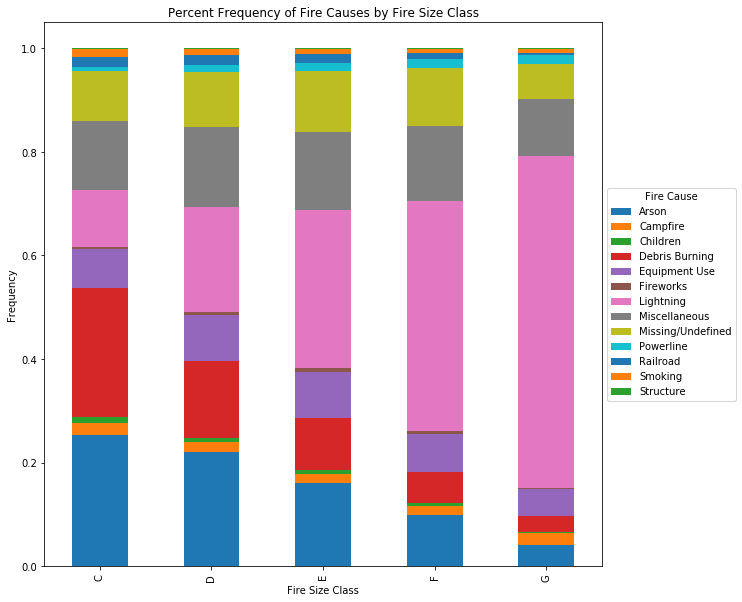

In [100]:
#Generate percent frequency bar chart 
fires_pv=pd.pivot_table(fires, index='FIRE_SIZE_CLASS', columns='STAT_CAUSE_DESCR',aggfunc='size')
p_table=fires_pv.div(fires_pv.sum(axis=1), axis=0)
fire_cause=p_table.plot.bar(stacked=True, title='Percent Frequency of Fire Causes by Fire Size Class',figsize=(10,10))
fire_cause.set_xlabel('Fire Size Class')
fire_cause.set_ylabel('Frequency')
plt.legend(loc='center left',bbox_to_anchor=(1.0, 0.5), title='Fire Cause')

## Model: Multilayer Perceptron

Our first model is a Multilayer Perceptron. The model takes the day of the year, time of day, cause, latitude, and longitude of discovery of a fire as input features and predicts a classification for the final size of the fire as an output feature. The size of the fire in acres is divided into classes as specified by the NWCG. Clearly, a different response is needed for different size fires. This model could assist in predicting the necessary magnitude of response to a newly discovered wildfire based on very few features. With 15 input nodes and 5 output nodes, we chose a one hidden layer of 15 nodes. Fires of size less than 10 acres were not included because of their insignificance and the noise they introduced.

In [101]:
#Import packages
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

In [102]:
#Convert STAT_CAUSE_CODE to strings
fires['STAT_CAUSE_CODE']=fires['STAT_CAUSE_CODE'].astype(str)

In [103]:
#Create a column for each cause code in firescopy, default value 0
for i in range(1,14):
    fires['%s.0'%i]=0

In [104]:
#If a row's cause code matches a column's, set row value for column to 1
for i in range(1,14):
    fires.loc[fires['STAT_CAUSE_CODE']=='%s.0'%i,'%s.0'%i]=1

In [105]:
#Create X using all features (including y feature), dropna, remove y feature from x
X=fires[['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','1.0','2.0','3.0','4.0','5.0','6.0','7.0','8.0','9.0','10.0','11.0','12.0','13.0','FIRE_SIZE_CLASS']].dropna(axis=0,)
y=X['FIRE_SIZE_CLASS']
X=X.drop('FIRE_SIZE_CLASS',axis=1)

In [106]:
#Create train/test sets
xTr, xTe, yTr, yTe = train_test_split(X, y, test_size=0.2,random_state=42)

In [107]:
scaler = StandardScaler()

In [108]:
#Fit scaler to x train
scaler.fit(xTr)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [109]:
#Apply scaler to x
xTr = scaler.transform(xTr)
xTe = scaler.transform(xTe)

In [110]:
#Create MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(17),random_state=42)

In [111]:
#Fit mlp to training data
mlp.fit(xTr,yTr)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=17, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [112]:
#Generate predictions from testing data
predictions = mlp.predict(xTe)

In [113]:
#Generate accuracy score from predictions/testing data
accuracy_score(yTe, predictions)

0.7579319671278477

## Model: KNN

The second model we chose to make our prediction is the k-Nearest-Neighbor model. This algorithm is known for it's classification ability. We expect it to be able to cluster our input features with respect to our output features, especially considering that two of the inputs are geographical. For this model, we used the wildfire's longitude, latitude, and discovery month. We did not include the fire cause because it is categorical data. However, even though the model had less information to base its prediction from, it was able to predict the final fire size with slightly greater accuracy than the neural network. We chose an n_neighbors value of 50 by calculating the accuracies of 10 different n_neighbors values from 5 to 50.

In [114]:
#Import packages
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [115]:
#Create fires column describing discovery month in format MM
fires['DISCOVERY_MM']=fires['DISCOVERY_DATE'].apply(str).str.slice(5,7)

In [116]:
#Create x and y
x=fires[['LONGITUDE', 'LATITUDE', 'DISCOVERY_MM']]
x=x.dropna()
y=fires['FIRE_SIZE_CLASS']

In [117]:
#Create train/test/split
xTr,xTe,yTr,yTe=train_test_split(x,y,test_size=0.2, random_state=3)

In [140]:
#Test n_neighbors values: 50 will do
for i in range(0,10):
    i=5+i*5
    Kmodel=KNeighborsClassifier(n_neighbors=i)
    Kmodel.fit(xTr,yTr)
    predictions=Kmodel.predict(xTe)
    print("i: %s acc: %s" % (i,accuracy_score(yTe,predictions)))

i: 5 acc: 0.7848050479629427
i: 10 acc: 0.796513112302586
i: 15 acc: 0.7992486413539045
i: 20 acc: 0.8011270379691432
i: 25 acc: 0.80152824889667
i: 30 acc: 0.8018565123828282
i: 35 acc: 0.8024036181930919
i: 40 acc: 0.8024765656344603
i: 45 acc: 0.8028230659809608
i: 50 acc: 0.8028413028413028


In [141]:
#Create KNN model
Kmodel=KNeighborsClassifier(n_neighbors=50)

In [142]:
#Fit model to training data
Kmodel.fit(xTr,yTr)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=50, p=2,
           weights='uniform')

In [143]:
#Use model to predict testing data
predictions=Kmodel.predict(xTe)

In [144]:
#Score accuracy of predictions on testing data
accuracy_score(yTe, predictions)

0.8028413028413028